# [How to use TensorBoard in Flax](https://www.machinelearningnuggets.com/how-to-use-tensorboard-in-flax)

 [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlnuggets/flax/blob/main/tensorboard/tensorboard.ipynb)


Dataset is obtained from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats).

Click the image below to read the post online.

<a target="_blank" href="https://www.machinelearningnuggets.com/how-to-use-tensorboard-in-flax
"><img src="https://digitalpress.fra1.cdn.digitaloceanspaces.com/mhujhsj/2022/07/logo.png" alt="Open in ML Nuggets"></a>

In [ ]:
pip install wget

In [ ]:
pip install flax

In [ ]:
import wget 
wget.download("https://ml.machinelearningnuggets.com/train.zip")

In [48]:
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall('.')

## Perform standard imports

In [49]:
import torch
from torch.utils.data import DataLoader
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [50]:
import jax
from jax import numpy as jnp
import flax
from flax import linen as nn  
from flax.training import train_state
import optax

In [51]:
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [52]:
train_df = pd.DataFrame(columns=["img_path","label"])
train_df["img_path"] = os.listdir("train/")
for idx, i in enumerate(os.listdir("train/")):
    if "cat" in i:
        train_df["label"][idx] = 0
    if "dog" in i:
        train_df["label"][idx] = 1

train_df.to_csv (r'train_csv.csv', index = False, header=True)

In [53]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])
    return imgs, labels

In [54]:
size_image = 28
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((size_image,size_image)),
    np.array])
dataset = CatsDogsDataset("train","train_csv.csv",transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[20000,5000])
train_loader = DataLoader(dataset=train_set, collate_fn=custom_collate_fn,shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(dataset=validation_set,collate_fn=custom_collate_fn, shuffle=False, batch_size=batch_size)

In [ ]:
(image_batch, label_batch) = next(iter(train_loader))
print(image_batch.shape)
print(label_batch.shape)

In [ ]:
image_batch.shape[0]

## Tensorboard

In [57]:
from torch.utils.tensorboard import SummaryWriter
logdir = "runs"

writer = SummaryWriter(logdir)

In [58]:

import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

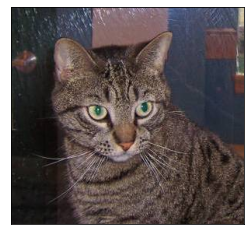

In [59]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

cat = read_image(str(Path('train') / 'cat.1.jpg'))
grid = make_grid(cat)
show(grid)

In [60]:
writer.add_text('Text', 'Write image to TensorBoard', 0)
writer.add_image('sample_cat', grid)


In [61]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir={logdir}

In [63]:
class CNN(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=2)(x)
    x = nn.log_softmax(x)
    return x

In [64]:
def cross_entropy_loss(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=2)
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

In [65]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [66]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, size_image, size_image, 3]))['params']
  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

In [67]:
def compute_loss(params,images,labels):
    logits = CNN().apply({'params': params}, images)
    loss = cross_entropy_loss(logits=logits, labels=labels)
    return loss, logits

In [68]:
@jax.jit
def train_step(state,images, labels):
  """Train for a single step."""
  (_, logits), grads = jax.value_and_grad(compute_loss, has_aux=True)(state.params,images,labels)
  state = state.apply_gradients(grads=grads) 
  metrics = compute_metrics(logits=logits, labels=labels) 
  return state, metrics

In [69]:
@jax.jit
def eval_step(state, images, labels):
    logits = CNN().apply({'params': state.params}, images)
    return compute_metrics(logits=logits, labels=labels)

In [70]:
import numpy as np
def train_one_epoch(state, dataloader):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for images, labels in dataloader:
        images = images / 255.0
        state, metrics = train_step(state, images, labels)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)  
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
   

    return state, epoch_metrics_np


In [71]:
def evaluate_model(state, test_imgs, test_lbls):
    """Evaluate on the validation set."""
    metrics = eval_step(state, test_imgs, test_lbls)
    metrics = jax.device_get(metrics) 
    metrics = jax.tree_map(lambda x: x.item(), metrics)  
    return metrics

In [72]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [73]:
learning_rate = 0.1
momentum = 0.9
seed = 0 

In [74]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [75]:
num_epochs = 30

In [76]:
(test_images, test_labels) = next(iter(validation_loader))
test_images = test_images / 255.0

In [77]:
state = create_train_state(jax.random.PRNGKey(seed), learning_rate, momentum)
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []

In [ ]:
for epoch in range(1, num_epochs + 1):
    train_state, train_metrics = train_one_epoch(state, train_loader)
    training_loss.append(train_metrics['loss'])
    training_accuracy.append(train_metrics['accuracy'])
    print(f"Train epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy'] * 100}")

    test_metrics = evaluate_model(train_state, test_images, test_labels)
    testing_loss.append(test_metrics['loss'])
    testing_accuracy.append(test_metrics['accuracy'])

    writer.add_scalar('Loss/train', train_metrics['loss'], epoch)
    writer.add_scalar('Loss/test', test_metrics['loss'], epoch)
    
    writer.add_scalar('Accuracy/train', train_metrics['accuracy'], epoch)
    writer.add_scalar('Accuracy/test', test_metrics['accuracy'], epoch)

    print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")
writer.flush()

In [79]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir={logdir}

In [ ]:
!tensorboard dev upload --logdir ./runs \
  --name "Flax experiments" \
  --description "Logging model metrics with JAX" \


## Where to go from here
Follow us on [LinkedIn](https://www.linkedin.com/company/mlnuggets), [Twitter](https://twitter.com/ml_nuggets), [GitHub](https://github.com/mlnuggets) and subscribe to our [blog](https://www.machinelearningnuggets.com/#/portal) so that you don't miss a new issue.